<>:265: SyntaxWarning: invalid escape sequence '\s'
<>:265: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kd/ch5dsx357yg2zrg8f0kr0nr00000gn/T/ipykernel_18097/74847278.py:265: SyntaxWarning: invalid escape sequence '\s'
  ax0.set_xlabel(f"$\sigma$ (Out-of-Sample {H}-week Volatility)", fontsize=14)


1. Configuring simulation parameters...
2. Loading and preparing data...
3. Establishing Bayesian prior and 'Ground Truth' distribution...
   - Bayesian prior established from 503 historical observations.
   - 'Ground Truth' efficient frontier calculated for evaluation.

5. Starting Monte-Carlo simulation...
   - Running simulation 100/100...
Monte Carlo simulation finished successfully.
6. Calculating performance metrics...
7. Generating analysis plots...


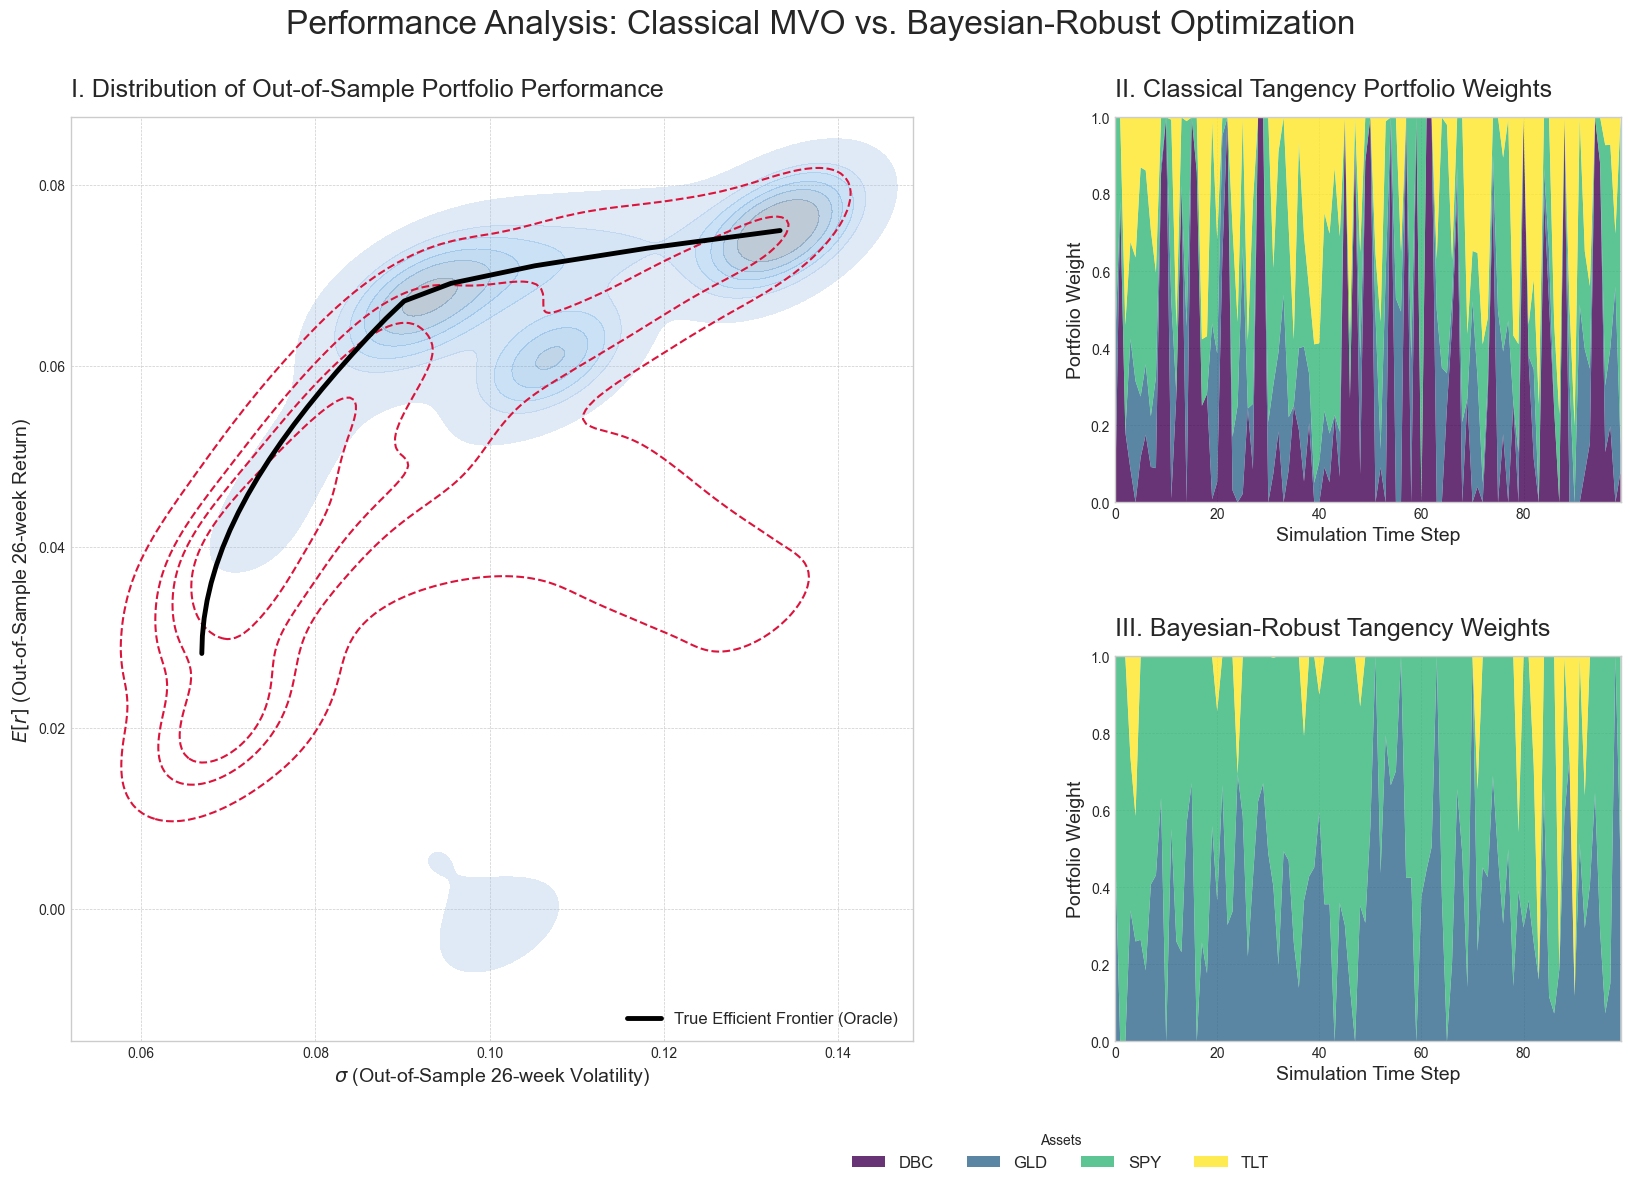

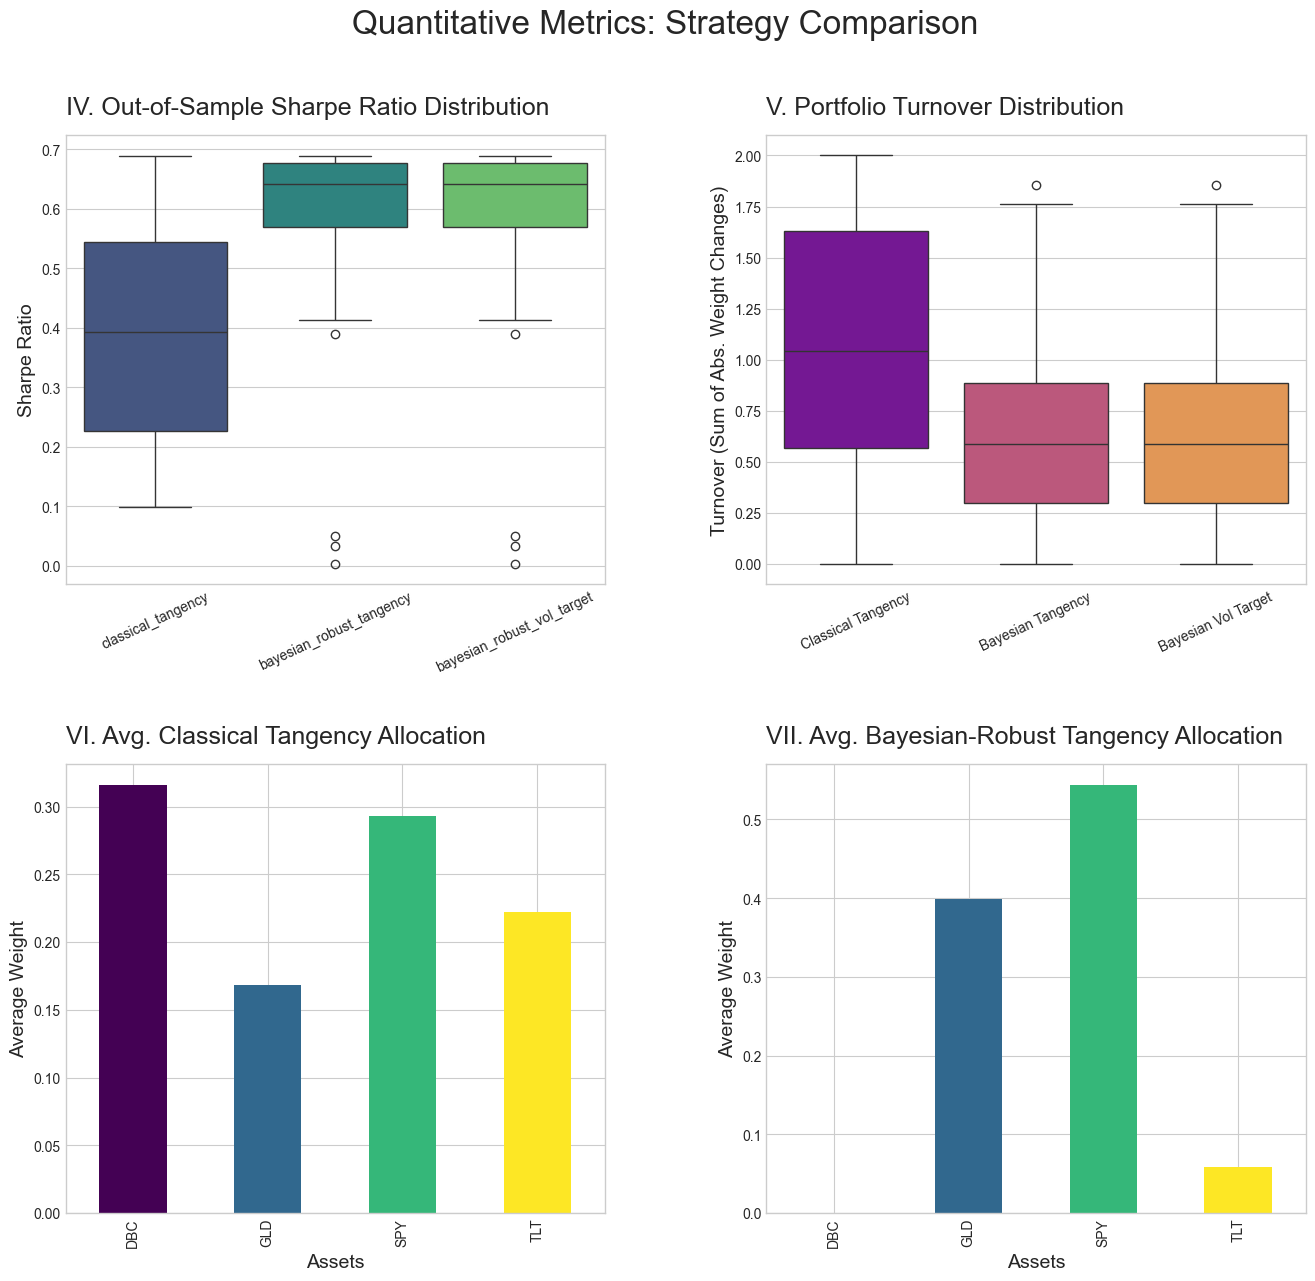


8. Summary of Performance Metrics (Averages over all simulations):

                            OOS Sharpe (Mean)  OOS Volatility (Mean)  \
Strategy                                                               
classical_tangency                     0.4094                 0.0934   
bayesian_robust_tangency               0.6028                 0.0997   
bayesian_robust_vol_target             0.6028                 0.0997   

                            Turnover  Num. Assets  OOS Return (Mean)  
Strategy                                                              
classical_tangency            1.0745         2.76             0.0423  
bayesian_robust_tangency      0.6425         1.97             0.0649  
bayesian_robust_vol_target    0.6425         1.97             0.0649  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
import logging

# --- Initial Setup ---
# Configure logging and plotting styles for a clean output.
logging.getLogger('pyvallocation').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# --- Import necessary components from the pyvallocation library ---
# This assumes the library is installed or in the Python path.
from pyvallocation.bayesian import NIWPosterior
from pyvallocation.portfolioapi import AssetsDistribution, PortfolioWrapper
from pyvallocation import moments
from pyvallocation.probabilities import generate_uniform_probabilities as uniform
from pyvallocation.utils.projection import project_mean_covariance, log2simple

# ───────────────────── 1. Simulation Parameters ───────────────────── #
print("1. Configuring simulation parameters...")

H, W = 26, 104  # Holding Period (26 weeks = 6 months), Lookback Window (104 weeks = 2 years)
N_SIM = 100     # Number of Monte Carlo simulations 
FRONTIER_PTS = 25
SEED = 0

# Define the "fair comparison" criteria for portfolio selection
RISK_FREE_RATE_ANNUAL = 0.01
VOLATILITY_TARGET = 0.03 # 3% volatility target for the H-week horizon

# Convert annual risk-free rate to the rate for our H-week holding period
RISK_FREE_RATE_H = (1 + RISK_FREE_RATE_ANNUAL)**(H / 52) - 1

# ───────────────────── 2. Data Preparation ────────────────────── #
print("2. Loading and preparing data...")
prices = pd.read_csv("examples/ETF_prices.csv", index_col=0, parse_dates=True).resample("W").ffill()


r_log = np.log(prices).diff().dropna()
ASSET_NAMES = r_log.columns.to_list()

# Split data: the first half establishes our long-term prior, the second is for simulation.
split_idx = len(r_log) // 2
prior_data = r_log.iloc[:split_idx]
sim_data = r_log.iloc[split_idx:]

# ─────── 3. Population & Prior Setup ─────────── #
print("3. Establishing Bayesian prior and 'Ground Truth' distribution...")

# First, establish the Bayesian prior from long-term historical data.
# This represents our stable, long-held beliefs about the market.
T0 = len(prior_data)
mu0_prior, sigma0_prior = moments.estimate_sample_moments(prior_data, uniform(T0))

# The confidence parameters t0 and nu0 are set to the number of observations,
# giving the prior significant weight. This reflects strong belief in historical data.
niw_prior_model = NIWPosterior(prior_mu=mu0_prior, prior_sigma=sigma0_prior, t0=T0, nu0=T0)
print(f"   - Bayesian prior established from {T0} historical observations.")

# Second, define the "Ground Truth" or "Oracle" distribution from the full
# simulation period. This is what we use to evaluate performance out-of-sample.
# In the real world, this is unknown, but in a simulation, it's our benchmark for truth.
μ_population, Σ_population = log2simple(*project_mean_covariance(*moments.estimate_sample_moments(sim_data, uniform(len(sim_data))), H))
population_dist = AssetsDistribution(mu=μ_population, cov=Σ_population, asset_names=ASSET_NAMES)

# Generate the "True" Efficient Frontier for plotting as a reference
pw_population = PortfolioWrapper(population_dist)
pw_population.set_constraints({'long_only': True, 'total_weight': 1.0})
ef_population = pw_population.mean_variance_frontier(FRONTIER_PTS)
print("   - 'Ground Truth' efficient frontier calculated for evaluation.")


# ───────────── 4. Estimator Functions ──────────────── #

def estimate_classical_shrinkage_params(r_window: pd.DataFrame):
    """
    Estimates parameters using classical methods with shrinkage.
    This serves as a strong, sophisticated baseline for MVO.
    """
    p_win = uniform(len(r_window))
    mu_sample, sigma_sample = moments.estimate_sample_moments(r_window, p_win)

    # Apply shrinkage to correct for estimation error in a classical framework
    sigma_shrink = moments.shrink_covariance_ledoit_wolf(r_window, sigma_sample)
    mu_shrink = moments.shrink_mean_jorion(mu_sample, sigma_shrink, len(r_window))

    # Project to the desired holding period horizon
    return log2simple(*project_mean_covariance(mu_shrink, sigma_shrink, H))

def estimate_bayesian_robust_params(r_window: pd.DataFrame, niw_model: NIWPosterior):
    """
    Updates the NIW posterior with new data and returns parameters for robust optimization.
    """
    mu_sample, sigma_sample = moments.estimate_sample_moments(r_window, uniform(len(r_window)))

    # The core Bayesian step: update the prior with new market evidence
    niw_model.update(sample_mu=mu_sample, sample_sigma=sigma_sample, n_obs=len(r_window))

    # Retrieve the posterior parameters. These are "classical-equivalent" (ce) estimators.
    mu_ce = niw_model.get_mu_ce()          # Posterior mean estimate
    sigma_ce = niw_model.get_sigma_ce()    # Posterior covariance estimate
    s_mu = niw_model.get_S_mu()            # CRITICAL: Posterior uncertainty matrix for the mean

    # Project all parameters to the holding period horizon
    mu_ce_proj, sigma_ce_proj = log2simple(*project_mean_covariance(mu_ce, sigma_ce, H))
    _, s_mu_proj = log2simple(*project_mean_covariance(mu_ce, s_mu, H)) # mu_ce is already projected

    return mu_ce_proj, sigma_ce_proj, s_mu_proj

def evaluate_weights_on_truth(W, μ_true, Σ_true):
    """
    Helper function to calculate the out-of-sample risk/return of given portfolio weights.
    """
    if W is None or W.size == 0:
        return []
    W = np.asarray(W)
    if W.ndim == 1:
        W = W.reshape(-1, 1)

    # Evaluate weights against the "true" population parameters
    out_of_sample_returns = W.T @ μ_true
    out_of_sample_risks = np.sqrt(np.einsum("ik,ji,jk->k", W, Σ_true, W))
    return list(zip(out_of_sample_risks.ravel(), out_of_sample_returns.ravel()))


# ───────────── 5. Monte-Carlo Simulation ───────────── #
print("\n5. Starting Monte-Carlo simulation...")
rng = np.random.default_rng(SEED)
# Generate random starting points for our rolling windows
start_indices = rng.integers(0, len(sim_data) - W, N_SIM)

# Dictionaries to store results for later analysis
out_of_sample_points = {"classical": [], "bayesian_robust": []}
portfolio_weights = {
    "classical_tangency": [], "classical_vol_target": [],
    "bayesian_robust_tangency": [], "bayesian_robust_vol_target": []
}

for i, s_idx in enumerate(start_indices):
    print(f"   - Running simulation {i+1}/{N_SIM}...", end='\r')
    r_window = sim_data.iloc[s_idx : s_idx + W]

    # Re-initialize the NIW model for each trial to ensure independence
    niw_prior_model_sim = NIWPosterior(prior_mu=mu0_prior, prior_sigma=sigma0_prior, t0=T0, nu0=T0)

    # Estimate parameters using both methods for the current window
    mu_classical, sigma_classical = estimate_classical_shrinkage_params(r_window)
    mu_bayes, sigma_bayes, s_mu_bayes = estimate_bayesian_robust_params(r_window, niw_prior_model_sim)

    try:
        # --- Method 1: Classical MVO with Shrinkage ---
        classical_dist = AssetsDistribution(mu=mu_classical, cov=sigma_classical, asset_names=ASSET_NAMES)
        pw_classical = PortfolioWrapper(classical_dist)
        pw_classical.set_constraints({'long_only': True, 'total_weight': 1.0})
        classical_frontier = pw_classical.mean_variance_frontier(FRONTIER_PTS)

        # Evaluate the entire frontier out-of-sample
        out_of_sample_points["classical"].extend(evaluate_weights_on_truth(classical_frontier.weights, μ_population, Σ_population))

        w_cla_tan, _, _ = classical_frontier.get_tangency_portfolio(RISK_FREE_RATE_H)
        if not w_cla_tan.isnull().any():
            portfolio_weights["classical_tangency"].append(w_cla_tan.values)

        w_cla_vol, _, _ = classical_frontier.portfolio_at_risk_target(VOLATILITY_TARGET)
        if not w_cla_vol.isnull().any():
            portfolio_weights["classical_vol_target"].append(w_cla_vol.values)

        # --- Method 2: Bayesian-Robust MVO ---
        robust_dist = AssetsDistribution(mu=mu_bayes, cov=s_mu_bayes, asset_names=ASSET_NAMES)
        pw_robust = PortfolioWrapper(robust_dist)
        pw_robust.set_constraints({'long_only': True, 'total_weight': 1.0})
        robust_frontier = pw_robust.robust_lambda_frontier(FRONTIER_PTS, max_lambda=2.0)

        out_of_sample_points["bayesian_robust"].extend(evaluate_weights_on_truth(robust_frontier.weights, μ_population, Σ_population))

        w_bayes_tan, _, _ = robust_frontier.get_tangency_portfolio(RISK_FREE_RATE_H)
        if not w_bayes_tan.isnull().any():
            portfolio_weights["bayesian_robust_tangency"].append(w_bayes_tan.values)

        in_sample_vols_bayes = np.sqrt(np.einsum('ik,ji,jk->k', robust_frontier.weights, sigma_bayes, robust_frontier.weights))
        idx_vol_target_bayes = np.argmin(np.abs(in_sample_vols_bayes - VOLATILITY_TARGET))
        w_bayes_vol = robust_frontier.weights[:, idx_vol_target_bayes]
        portfolio_weights["bayesian_robust_vol_target"].append(w_bayes_vol)

    except (RuntimeError, ValueError) as e:
        print(f"\nSkipping simulation step due to solver error: {e}")
        continue

print("\nMonte Carlo simulation finished successfully.")

# Convert list of weight arrays into DataFrames for easier analysis
weights_dfs = {key: pd.DataFrame(w_list, columns=ASSET_NAMES) for key, w_list in portfolio_weights.items()}

# ───────────────────── 6. Performance Metrics Calculation ─────────────────── #
print("6. Calculating performance metrics...")

metrics_results = {}

for name, weights_df in weights_dfs.items():
    if weights_df.empty:
        continue

    # Calculate out-of-sample returns and risks for the series of portfolios
    oos_returns = weights_df.values @ μ_population
    oos_risks = np.sqrt(np.einsum('ij,jk,ik->i', weights_df.values, Σ_population, weights_df.values))

    # Calculate Sharpe Ratios
    sharpe_ratios = (oos_returns - RISK_FREE_RATE_H) / oos_risks

    # Calculate Turnover (average absolute change in weights from one period to the next)
    turnover = weights_df.diff().abs().sum(axis=1).mean()

    # Calculate Average Number of Assets with significant weight (>1%)
    num_assets = (weights_df > 0.01).sum(axis=1).mean()
    
    # Store all metrics
    metrics_results[name] = {
        'OOS Return (Mean)': oos_returns.mean(),
        'OOS Volatility (Mean)': oos_risks.mean(),
        'OOS Sharpe (Mean)': sharpe_ratios.mean(),
        'OOS Sharpe (Std)': sharpe_ratios.std(),
        'Turnover': turnover,
        'Num. Assets': num_assets,
        'Sharpe Ratios': sharpe_ratios # Keep the full list for plotting
    }

metrics_df = pd.DataFrame.from_dict(metrics_results, orient='index')


# ───────────────────── 7. Plotting Monte Carlo Results ─────────────────────── #
print("7. Generating analysis plots...")

# --- PLOT 1: Main performance plot (same as before) ---
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1.5], height_ratios=[1, 1], hspace=0.4, wspace=0.3)
ax0 = fig.add_subplot(gs[:, 0])
fig.suptitle("Performance Analysis: Classical MVO vs. Bayesian-Robust Optimization", fontsize=24, y=0.97)

ax0.plot(ef_population.risks, ef_population.returns, "k-", lw=3.5, zorder=10, label="True Efficient Frontier (Oracle)")

if out_of_sample_points["classical"]:
    cla_risks, cla_rets = zip(*out_of_sample_points["classical"])
    sns.kdeplot(x=cla_risks, y=cla_rets, color="crimson", linestyles="--", levels=5, ax=ax0, label="Classical MVO Frontiers")

if out_of_sample_points["bayesian_robust"]:
    bayes_risks, bayes_rets = zip(*out_of_sample_points["bayesian_robust"])
    sns.kdeplot(x=bayes_risks, y=bayes_rets, color="steelblue", fill=True, alpha=0.35, levels=7, ax=ax0, label="Bayesian-Robust Frontiers")

ax0.set_title("I. Distribution of Out-of-Sample Portfolio Performance", fontsize=18, pad=15, loc='left')
ax0.set_xlabel(f"$\sigma$ (Out-of-Sample {H}-week Volatility)", fontsize=14)
ax0.set_ylabel(f"$E[r]$ (Out-of-Sample {H}-week Return)", fontsize=14)
ax0.legend(loc='lower right', fontsize=12)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2 & 3: Weight Stability Analysis ---
asset_colors = plt.cm.viridis(np.linspace(0, 1, len(ASSET_NAMES)))

def plot_weight_stability(ax, weights_df, title):
    """Helper to create a stacked area plot of portfolio weights over time."""
    if weights_df.empty:
        ax.text(0.5, 0.5, "No valid portfolios found.", ha='center', va='center')
        ax.set_title(title, fontsize=18, pad=15, loc='left')
        return
    ax.stackplot(weights_df.index, weights_df.T, labels=weights_df.columns, colors=asset_colors, alpha=0.8)
    ax.set_title(title, fontsize=18, pad=15, loc='left')
    ax.set_ylabel("Portfolio Weight", fontsize=14)
    ax.set_xlabel("Simulation Time Step", fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(weights_df)-1)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax1 = fig.add_subplot(gs[0, 1])
plot_weight_stability(ax1, weights_dfs.get("classical_tangency", pd.DataFrame()), "II. Classical Tangency Portfolio Weights")

ax2 = fig.add_subplot(gs[1, 1])
plot_weight_stability(ax2, weights_dfs.get("bayesian_robust_tangency", pd.DataFrame()), "III. Bayesian-Robust Tangency Weights")

handles, labels = ax2.get_legend_handles_labels()
if handles: # Only create legend if there are labels to show
    fig.legend(handles, labels, loc='lower center', ncol=len(ASSET_NAMES), bbox_to_anchor=(0.62, -0.01), fontsize=12, title="Assets")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


# --- PLOT 2: New plots for detailed metrics ---
fig2 = plt.figure(figsize=(16, 14))
gs2 = gridspec.GridSpec(2, 2, hspace=0.4, wspace=0.3)
fig2.suptitle("Quantitative Metrics: Strategy Comparison", fontsize=24, y=0.97)

# --- Plot 4: Sharpe Ratio Distribution ---
ax3 = fig2.add_subplot(gs2[0, 0])
sharpe_data_for_plot = {k: v['Sharpe Ratios'] for k, v in metrics_results.items()}
sharpe_df_plot = pd.DataFrame(sharpe_data_for_plot)
sns.boxplot(data=sharpe_df_plot, ax=ax3, palette='viridis')
ax3.set_title("IV. Out-of-Sample Sharpe Ratio Distribution", fontsize=18, pad=15, loc='left')
ax3.set_ylabel("Sharpe Ratio", fontsize=14)
ax3.tick_params(axis='x', rotation=25)

# --- Plot 5: Turnover Distribution ---
ax4 = fig2.add_subplot(gs2[0, 1])
turnover_data = {
    'Classical Tangency': weights_dfs.get('classical_tangency', pd.DataFrame()).diff().abs().sum(axis=1),
    'Bayesian Tangency': weights_dfs.get('bayesian_robust_tangency', pd.DataFrame()).diff().abs().sum(axis=1),
    'Classical Vol Target': weights_dfs.get('classical_vol_target', pd.DataFrame()).diff().abs().sum(axis=1),
    'Bayesian Vol Target': weights_dfs.get('bayesian_robust_vol_target', pd.DataFrame()).diff().abs().sum(axis=1)
}
# Filter out empty dataframes
turnover_data_filtered = {k: v for k, v in turnover_data.items() if not v.empty}
turnover_df_plot = pd.DataFrame(turnover_data_filtered)

sns.boxplot(data=turnover_df_plot, ax=ax4, palette='plasma')
ax4.set_title("V. Portfolio Turnover Distribution", fontsize=18, pad=15, loc='left')
ax4.set_ylabel("Turnover (Sum of Abs. Weight Changes)", fontsize=14)
ax4.tick_params(axis='x', rotation=25)


# --- Plot 6 & 7: Average Asset Allocation ---
def plot_average_weights(ax, weights_df, title):
    if weights_df.empty:
        ax.text(0.5, 0.5, "No valid portfolios.", ha='center', va='center')
    else:
        avg_weights = weights_df.mean()
        avg_weights.plot(kind='bar', ax=ax, color=asset_colors)
    ax.set_title(title, fontsize=18, pad=15, loc='left')
    ax.set_ylabel("Average Weight", fontsize=14)
    ax.set_xlabel("Assets", fontsize=14)
    ax.axhline(0, color='black', lw=0.5)
    ax.set_ylim(bottom=0)

ax5 = fig2.add_subplot(gs2[1, 0])
plot_average_weights(ax5, weights_dfs.get('classical_tangency', pd.DataFrame()), "VI. Avg. Classical Tangency Allocation")

ax6 = fig2.add_subplot(gs2[1, 1])
plot_average_weights(ax6, weights_dfs.get('bayesian_robust_tangency', pd.DataFrame()), "VII. Avg. Bayesian-Robust Tangency Allocation")


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ───────────────────── 8. Display Final Metrics Summary ─────────────────────── #
print("\n8. Summary of Performance Metrics (Averages over all simulations):\n")
# Select and reorder columns for clarity
summary_cols = ['OOS Sharpe (Mean)', 'OOS Volatility (Mean)', 'Turnover', 'Num. Assets', 'OOS Return (Mean)']
final_summary = metrics_df[summary_cols].copy()
final_summary.index.name = "Strategy"
print(final_summary.round(4))